In [4]:
import numpy as np
np.random.seed = 42

In [5]:
import lambeq as lq
parser = lq.BobcatParser()

In [6]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-50")

In [ ]:
from lambeq import Rewriter
from lambeq import UnifyCodomainRewriter
from lambeq import AtomicType
from lambeq import IQPAnsatz

In [ ]:
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import StatevectorSampler

In [ ]:
from scipy.optimize import minimize 

In [486]:
def get_param_for_word(word):
    try:
        return np.linalg.norm(word_vectors[word.lower()]) 
    except KeyError:
        return (np.random.uniform(-1, 1, 1)[0])

In [487]:
def sentence_encoder(sentence):
    diagram = parser.sentence2diagram(sentence)

    rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary'])
    rewritten_diagram = rewriter(diagram)

    normalised_diagram = rewritten_diagram.normal_form()

    
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE
    
    rewriter = UnifyCodomainRewriter(output_type=S)

    unified_diagram = rewriter(normalised_diagram)

    
    ansatz = IQPAnsatz({N: 2, S: 2}, n_layers=5)
    circuit = ansatz(unified_diagram)


    tket_circuit = circuit.to_tk()
    qiskit_circuit = tk_to_qiskit(tket_circuit)


    params = {}
    param_type = {'input':[], 'weight':[]}
    for i in qiskit_circuit.parameters:
        if(i._name[-1]=='0'):
            params[i] = get_param_for_word(i.name.split('_')[0])
            param_type['input'].append(i)
        else:
            params[i] = (np.random.uniform(-1, 1, 1)[0])
            param_type['weight'].append(i)

    def scale_dict_values_to_minus_one_one(d):
        min_val = min(d.values())
        max_val = max(d.values())
        
        def scale_value(x, min_val, max_val):
            return 2 * (x - min_val) / (max_val - min_val) - 1
        
        scaled_dict = {k: scale_value(v, min_val, max_val) for k, v in d.items()}
        return scaled_dict

    scaled_params = scale_dict_values_to_minus_one_one(params)
    sampler_qnn = SamplerQNN(circuit=qiskit_circuit, input_params=param_type['input'], weight_params=param_type['weight'])
    sampler_qnn_input = []
    sampler_qnn_weights = []
    for i in sampler_qnn.input_params:
        sampler_qnn_input.append(params[i])
    for i in sampler_qnn.weight_params:
        sampler_qnn_weights.append(params[i])

    def cost_function(weights):
        output_probs = sampler_qnn.forward(sampler_qnn_input, weights)
        prob_zero_state = output_probs[0][0]
        # The cost should be minimized, so we penalize 1 - the probability of |00...0⟩
        #return (1 - prob_zero_state)
        return -np.log(prob_zero_state)
    
    optimized_weights = minimize(fun=cost_function, x0=sampler_qnn_weights, method='COBYLA')
    
    optimized_params = {}
    indx = 0
    for i in param_type['input']:
        optimized_params[i] = sampler_qnn_input[indx]
        indx+=1

    indx = 0
    for i in param_type['weight']:
        optimized_params[i] = optimized_weights.x[indx]
        indx+=1
    
    sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, optimized_weights.x)

    qubitdat = {"measured":[], "unmeasured":[]}
    for i in qiskit_circuit.data:
        if (i.operation.name == 'measure'):
            qubitdat["measured"].append(i.qubits[0]._index)



    for i in range(qiskit_circuit.num_qubits):
        if(i not in qubitdat['measured']):
            qubitdat['unmeasured'].append(i)
    
    observables = []
    n = qiskit_circuit.num_qubits
    for i in qubitdat['unmeasured']:
        observables.append('I'*i+'Z'+'I'*(n-i-1))
        observables.append('I'*i+'Y'+'I'*(n-i-1))
    observables = SparsePauliOp(observables)
    opt_qis_circ = qiskit_circuit.assign_parameters(optimized_params,inplace=False)
    estimator = StatevectorEstimator()
    pass_manager = generate_preset_pass_manager(optimization_level=3)
    isa_circuit = pass_manager.run(opt_qis_circ)
    qc_no_measure = QuantumCircuit(isa_circuit.num_qubits)

    for instruction, qubits, clbits in isa_circuit:
        if instruction.name != "measure":
            qc_no_measure.append(instruction, qubits, clbits)

    isa_observables = observables.apply_layout(isa_circuit.layout)
    pubs = [(qc_no_measure, isa_observable) for isa_observable in isa_observables]
    job = estimator.run(pubs)
    res = job.result()
    encoded_vect_for_sentence = []

    for i in res:
        encoded_vect_for_sentence.append(i.data.evs)
    return encoded_vect_for_sentence

In [1]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append(t)
            sentences.append(line[1:].strip())
    return labels, sentences


In [2]:
train_labels, train_data = read_data('train.txt')
test_labels, test_data = read_data('test.txt')

In [493]:
#this will take a long time to compute if you decide to run it
train_data_vector = [sentence_encoder(s) for s in train_data]
test_data_vector = [sentence_encoder(s) for s in test_data]


In [3]:
train_features = np.array(train_data_vector)
test_features = np.array(test_data_vector)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

NameError: name 'np' is not defined

load features without running

In [ ]:
import pandas as pd
import numpy as np
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')
train_features
train_features = train_features.drop('Unnamed: 0', axis=1)
train_features = np.array(train_features)
test_features
test_features = test_features.drop('Unnamed: 0', axis=1)
test_features = np.array(test_features)

In [40]:
train_features

array([[ 1.05456349e-02,  5.79167709e-02,  3.10583691e-03,
         3.89573796e-02],
       [ 2.96670338e-01,  2.72764955e-01,  4.04564086e-01,
         1.64813234e-01],
       [ 1.64159823e-02,  9.78913325e-02,  3.96336408e-01,
        -2.78871656e-01],
       [-2.42576200e-01,  4.28943969e-01, -4.93262116e-01,
         9.61066430e-03],
       [ 2.80821522e-02, -8.60057885e-02,  1.22338526e-02,
         2.76098112e-02],
       [ 4.68341597e-02,  2.11254846e-02,  6.84176970e-02,
        -7.27349448e-02],
       [ 3.79856706e-01, -1.44954074e-01,  4.01905377e-01,
         6.82253374e-01],
       [ 6.96325722e-01,  2.84972109e-01,  7.26880319e-01,
        -3.35942550e-03],
       [ 7.10377292e-01, -4.53952890e-01,  8.43041395e-01,
         1.82325930e-04],
       [-6.97473487e-02,  1.85743195e-01, -1.94295382e-01,
         2.35863230e-02],
       [ 8.24043889e-04,  1.45748927e-02,  8.41236983e-03,
         7.52550460e-02],
       [ 5.36637225e-01,  2.18611722e-01,  3.54861948e-02,
      

In [43]:
train_labels

[1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0]

In [34]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import matplotlib as plt

feature_map = ZZFeatureMap(feature_dimension=4, reps=5, entanglement="full")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [35]:
from sklearn.svm import SVC

svc = SVC(kernel=kernel.evaluate)
svc.fit(train_features, train_labels)
score_callable_function =svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {score_callable_function}")

Callable kernel classification test score: 0.5


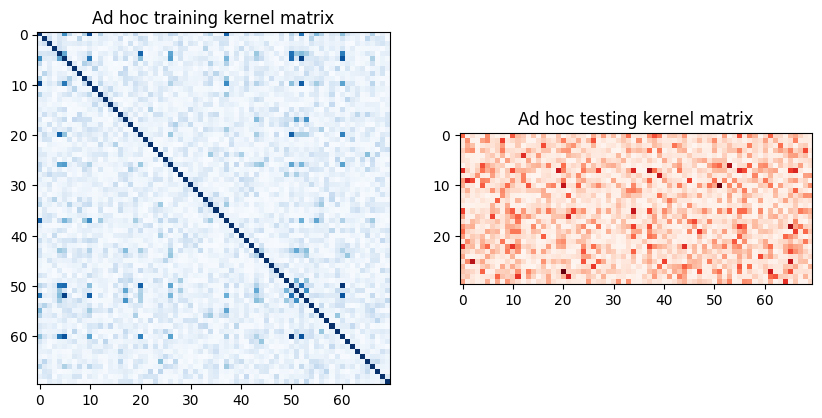

In [500]:
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [501]:
svc = SVC(kernel="precomputed")

svc.fit(matrix_train, train_labels)

score_precomputed_kernel =svc.score(matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

Precomputed kernel classification test score: 0.4666666666666667


In [502]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.4666666666666667


In [503]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       0.47
SVC using precomputed kernel matrix     |       0.47
QSVC                                    |       0.47


In [505]:
import pandas as pd

In [508]:
df = pd.DataFrame(test_features)

In [ ]:
df.to_csv('test_feat.csv')

In [510]:
df

,0,1,2,3
0,0.004449,-0.002300,0.146607,0.267143
1,0.843122,0.096477,0.437470,0.322612
2,0.084733,-0.147925,0.355148,-0.023138
3,0.446914,-0.398004,0.310671,0.458566
4,0.591419,-0.051295,0.152125,-0.176976
5,0.208342,-0.399017,0.994497,-0.050899
6,0.172024,-0.013185,0.164016,0.032585
7,0.518541,0.061918,0.521370,0.023406
8,0.318502,0.853990,-0.323785,0.397556
9,0.000140,-0.000184,0.951617,-0.209087


In [511]:
df = pd.DataFrame(train_features)

In [1]:
df

NameError: name 'df' is not defined